In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from classname import class_names
from Visualize_data import visualize_image_and_label, visualize_random_images
from tqdm import tqdm
import random
import supervision as sv

c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [97]:
#count the number of images in the data directory
def count_images(data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(images)

data_dir_train = 'data_aug/train/images'
data_dir_test = 'data_aug/test/images'
data_dir_val = 'data_aug/valid/images'
print(f'train: {count_images(data_dir_train)}')
print(f'test: {count_images(data_dir_test)}')
print(f'valid: {count_images(data_dir_val)}')


train: 6544
test: 231
valid: 491


Visualize data augmentation

In [12]:
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=40, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image = cv2.imread("data_aug/images/000067_jpg.rf.856d8c1c8745412cd1d2721b771411bf.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open("data_aug/images/000067_jpg.rf.856d8c1c8745412cd1d2721b771411bf.txt", 'r') as f:
    lines = f.readlines()

print(lines)

bboxes = []
class_labels = []

for line in lines:
    values = line.strip().split()[:5]  
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])


bboxes = [clip_bboxes(bbox) for bbox in bboxes]

augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_with_bbox)
plt.title('Augmented Image with New Bounding Boxes')
plt.axis('off')

plt.show()

print("Original bounding boxes:", bboxes)
print("Augmented bounding boxes:", augmented_bboxes)
print("Class Labels:", class_labels)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Augmentation 

In [ ]:
source_image_folder = 'merged_dataset_v1/train/images'
source_label_folder = 'merged_dataset_v1/train/labels'
aug_image_folder = 'data_aug/images'
aug_label_folder = 'data_aug/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

class_name_aug = [
    10,
    12,
    16,
    19,
    21,
    32
]

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in tqdm(os.listdir(source_image_folder), desc="Processing images"):
    if image_filename.endswith(('.jpg', '.png')):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.rsplit('.', 1)[0] + '.txt'
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                if len(values) >= 5:
                    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
                    bboxes.append([x_center, y_center, bbox_width, bbox_height])
                    class_labels.append(int(class_id))

            # Chỉ giữ lại các bounding boxes thuộc các lớp trong class_name_aug
            filtered_bboxes = []
            filtered_labels = []
            for bbox, label in zip(bboxes, class_labels):
                if label in class_name_aug:
                    filtered_bboxes.append(bbox)
                    filtered_labels.append(label)

            if not filtered_bboxes:  # Nếu không còn box nào sau khi lọc
                continue

            filtered_bboxes = [clip_bboxes(bbox) for bbox in filtered_bboxes]

            # Thực hiện augmentation chỉ cho các bounding boxes đã lọc
            augmented = transform(image=image, bboxes=filtered_bboxes, class_labels=filtered_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']
            augmented_labels = augmented['class_labels']

            # Lưu ảnh và label đã augment
            augmented_image_path = os.path.join(aug_image_folder, f'aug_{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            augmented_label_path = os.path.join(aug_label_folder, f'aug_{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, augmented_labels):
                    f.write(f"{int(class_id)} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")

Check label data

In [20]:
import random

source_image_folder = 'merged_dataset_v2/train/images'
source_label_folder = 'merged_dataset_v2/train/labels'
aug_image_folder = 'data_aug/images'
aug_label_folder = 'data_aug/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1), 
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Get a list of all image files in the source folder
all_image_files = [f for f in os.listdir(source_image_folder) if f.endswith(('.jpg', '.png'))]

# Randomly select 3000 images or all images if there are fewer than 3000
target_images = random.sample(all_image_files, min(3000, len(all_image_files)))

for image_filename in tqdm(target_images, desc="Processing images"):
    try:
        image_path = os.path.join(source_image_folder, image_filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_filename}. Skipping.")
            continue  
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(source_label_folder, label_filename)

        bboxes = []
        class_labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split() 
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

            bboxes.append([x_center, y_center, bbox_width, bbox_height])
            class_labels.append(int(class_id))  

        bboxes = [clip_bboxes(bbox) for bbox in bboxes]

        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented['image']
        augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
        
        augmented_image_path = os.path.join(aug_image_folder, f'aug_light_{image_filename}')  
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        augmented_label_path = os.path.join(aug_label_folder, f'aug_light_{label_filename}') 
        with open(augmented_label_path, 'w') as f:
            for bbox, class_id in zip(augmented_bboxes, class_labels):
                f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    except Exception as e:
        print(f"Error processing {image_filename}: {e}. Skipping.")

print("Light augmentation completed for randomly selected images.")


c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Processing images:   1%|▏         | 44/3000 [00:03<03:42, 13.29it/s]

Error processing IMG_20231120_111211174_jpg.rf.943854a9a0a3e32a0551bbc11630a817.jpg: Expected x_min for bbox [-1.2218952e-06  1.8229167e-01  4.4352174e-01  5.2083331e-01
  3.0000000e+00] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  13%|█▎        | 382/3000 [00:28<03:42, 11.78it/s]

Error processing IMG_20231120_110212407_jpg.rf.134f3d62a02465dd1a9f53bec3f36b1d.jpg: Expected x_min for bbox [-1.2218952e-06  1.8012206e-01  4.5817018e-01  5.9461749e-01
  2.5000000e+01] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  39%|███▉      | 1181/3000 [01:21<01:23, 21.85it/s]

Error processing image_0766_jpg.rf.1385c9ecbb86fda2e170b4da5ad9de2a.jpg: Expected y_min for bbox [ 5.6110002e-02 -1.0311604e-05  2.4555001e-01  2.4054639e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.0311603546142578e-05.. Skipping.


Processing images:  49%|████▉     | 1464/3000 [01:41<01:42, 14.92it/s]

Error processing IMG_20231120_105416013_jpg.rf.12f8f7b6363a03832c46b083d42d7a8f.jpg: Expected x_min for bbox [-1.2218952e-06  2.7994955e-01  4.4108033e-01  6.8467939e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  56%|█████▌    | 1670/3000 [01:54<01:05, 20.34it/s]

Error processing image_0937_jpg.rf.3ec56d674bca7f68d97a5951acb7b148.jpg: Expected x_min for bbox [-4.9993396e-06  4.8682475e-01  1.0166500e-01  6.7696905e-01
  1.7000000e+01] to be in the range [0.0, 1.0], got -4.999339580535889e-06.. Skipping.


Processing images:  60%|█████▉    | 1797/3000 [02:02<00:56, 21.45it/s]

Error processing 35d16e7e67_jpg.rf.8ca3a3da23bc14df52461254ed852236.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 1.2000000e+01] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.


Processing images:  61%|██████▏   | 1842/3000 [02:05<01:08, 17.03it/s]

Error processing VID_20240704_144255762_mp4-0006_jpg.rf.54e13e2b9ba646574bb96758fcb0445d.jpg: Expected y_min for bbox [ 2.5463021e-01 -4.6342611e-06  5.4629689e-01  2.7674538e-01
  0.0000000e+00] to be in the range [0.0, 1.0], got -4.634261131286621e-06.. Skipping.


Processing images:  88%|████████▊ | 2651/3000 [02:55<00:13, 26.43it/s]

Error processing image_1123_jpg.rf.1a2564f6742eeb64b0c4286c781692d2.jpg: Expected y_min for bbox [ 6.1166501e-01 -4.9993396e-06  7.4999499e-01  1.1666500e-01
  3.5000000e+01] to be in the range [0.0, 1.0], got -4.999339580535889e-06.. Skipping.


Processing images:  94%|█████████▍| 2820/3000 [03:06<00:06, 26.58it/s]

Error processing IMG_20231120_105331942_jpg.rf.0dfc711cfd57eb1a8fb3e08643883cba.jpg: Expected y_min for bbox [ 1.9938111e-01 -1.6391277e-06  9.8225951e-01  6.8250811e-01
  3.0000000e+00] to be in the range [0.0, 1.0], got -1.6391277313232422e-06.. Skipping.


Processing images: 100%|██████████| 3000/3000 [03:19<00:00, 15.00it/s]

Light augmentation completed for randomly selected images.


split data

In [7]:
import os
import random
import shutil
from collections import defaultdict

# Đường dẫn đến thư mục chứa ảnh và nhãn
image_folder = 'merged_dataset_v1/images'
label_folder = 'merged_dataset_v1/labels'
train_image_folder = 'merged_dataset_v1/train/images'
train_label_folder = 'merged_dataset_v1/train/labels'
val_image_folder = 'merged_dataset_v1/val/images'
val_label_folder = 'merged_dataset_v1/val/labels'

# Tạo thư mục mới nếu chưa tồn tại
os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(train_label_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(val_label_folder, exist_ok=True)

# Lưu danh sách các bức ảnh theo lớp
class_images = defaultdict(list)

# Đọc các file nhãn và phân loại ảnh theo lớp
for label_file in os.listdir(label_folder):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_folder, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                values = line.strip().split()
                class_id = int(values[0])  # Lấy ID lớp
                image_name = label_file.replace('.txt', '.jpg')  # Thay đổi đuôi nếu cần
                class_images[class_id].append(image_name)

# Chia dữ liệu cho từng lớp
for class_id, images in class_images.items():
    random.shuffle(images)  # Xáo trộn danh sách ảnh
    split_index = int(len(images) * 0.8)  # 80% cho train, 20% cho val
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Sao chép ảnh vào thư mục tương ứng
    for image_name in train_images:
        shutil.copy(os.path.join(image_folder, image_name), os.path.join(train_image_folder, image_name))
        # Sao chép nhãn tương ứng
        label_name = image_name.replace('.jpg', '.txt')  # Thay đổi đuôi nếu cần
        shutil.copy(os.path.join(label_folder, label_name), os.path.join(train_label_folder, label_name))

    for image_name in val_images:
        shutil.copy(os.path.join(image_folder, image_name), os.path.join(val_image_folder, image_name))
        # Sao chép nhãn tương ứng
        label_name = image_name.replace('.jpg', '.txt')  # Thay đổi đuôi nếu cần
        shutil.copy(os.path.join(label_folder, label_name), os.path.join(val_label_folder, label_name))

print("Chia tập dữ liệu hoàn tất.")

Chia tập dữ liệu hoàn tất.


In [8]:
names = ['Corrosive', 'Dangerous', 'Dangerous when wet', 'Environmentally Hazardous Substance', 'Explosives', 'Explosives Products considered extremely insensitive with no risk to create a mass explosion', 'Explosives Products considered very insensitive that are used as blasting agents', 'Explosives Products with no significant risk of creating a blast', 'Explosives Products with the potential to create a fire or minor blast', 'Explosives Products with the potential to create a projectile hazard Flammable', 'Flammable', 'Flammable and combustible liquids', 'Flammable gases', 'Flammable liquid', 'Flammable solids', 'Fuel oil', 'Hot', 'Infectious Substance', 'Miscellaneous', 'Nonflammable gases', 'Organic Peroxide', 'Oxidizer', 'Oxygen', 'Placards', 'Poison', 'Radioactive', 'Spontaneously combustible', 'Toxic gases', 'inhalation', 'license plate']

with open(r'C:\Users\Admin\Downloads\hazardous_oxi.v3i.yolov11\classes.txt', 'w') as f:
    for class_name in names:
        f.write(f"{class_name}\n")

print("Classes have been written to classes.txt")

Classes have been written to classes.txt


In [2]:
import os
from tqdm import tqdm

label_dir = "data_ogni/labels"

def check_and_delete_yolo_labels(label_dir):
    files_with_at_least_5_values = 0  
    files_deleted = 0  

    for label_file in tqdm(os.listdir(label_dir), desc="Checking label files"):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_dir, label_file)

            with open(label_path, "r") as f:
                valid_file = True  
                
                for line in f.readlines():
                    values = line.strip().split()
                    if len(values) > 5:
                        valid_file = False  
                        break 

            if valid_file:
                files_with_at_least_5_values += 1  
            else:
                os.remove(label_path) 
                files_deleted += 1

    # In kết quả sau khi kiểm tra
    print(f"Số lượng file hợp lệ (đúng 5 giá trị mỗi dòng): {files_with_at_least_5_values}")
    print(f"Số lượng file bị xóa (nhiều hơn 5 giá trị mỗi dòng): {files_deleted}")

# Gọi hàm kiểm tra và xóa file
check_and_delete_yolo_labels(label_dir)


Checking label files: 100%|██████████| 9665/9665 [00:01<00:00, 7287.68it/s]

Số lượng file hợp lệ (đúng 5 giá trị mỗi dòng): 7792
Số lượng file bị xóa (nhiều hơn 5 giá trị mỗi dòng): 1873


In [10]:
def count_class_labels(label_folder, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_folder, label_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.strip().split()
                    class_id = int(values[0])
                    if class_id < len(class_names):
                        class_counts[class_names[class_id]] += 1

    return class_counts

class_counts = count_class_labels('merged_dataset_v1/val/labels', class_names)
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Combustible: 69
Corrosive: 1203
Dangerous: 157
Dangerous when wet: 770
Environmentally Hazardous Substance: 417
Explosives: 1216
Explosives Products considered extremely insensitive with no risk to create a mass explosion: 70
Explosives Products considered very insensitive that are used as blasting agents: 103
Explosives Products with no significant risk of creating a blast: 102
Explosives Products with the potential to create a fire or minor blast: 50
Explosives Products with the potential to create a mass explosion: 63
Explosives Products with the potential to create a projectile hazard: 46
Flammable: 899
Flammable and combustible liquids: 568
Flammable gases: 303
Flammable liquid: 30
Flammable solids: 859
Fuel oil: 55
Hot: 39
Infectious Substance: 676
Miscellaneous: 91
Nonflammable gases: 983
Orange Panel: 216
Organic Peroxide: 706
Oxidizer: 261
Oxidizing substances: 864
Oxygen: 357
Placards: 308
Poison: 1299
Radioactive: 1017
Spontaneously combustible: 745
Toxic gases: 57
license p

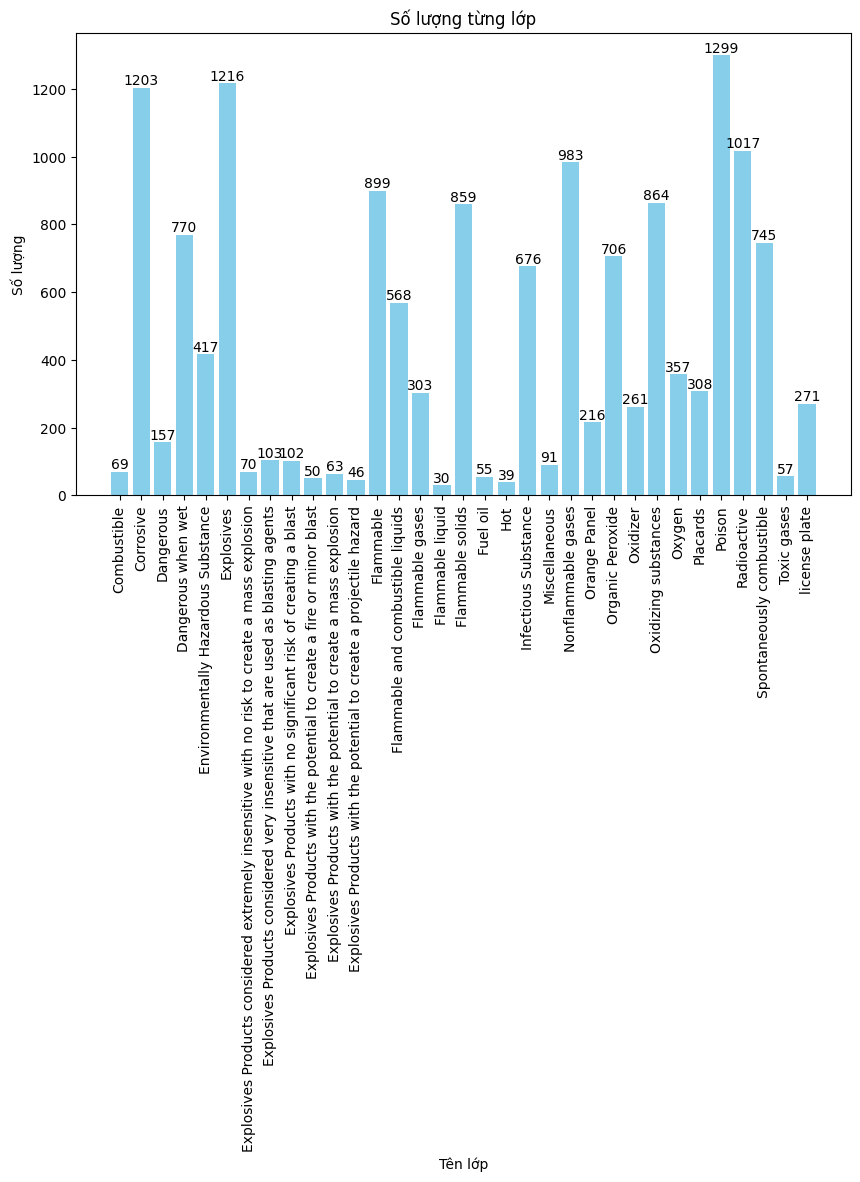

In [11]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Tên lớp')
plt.ylabel('Số lượng')
plt.title('Số lượng từng lớp')
plt.xticks(rotation=90)

# Ghi số lượng ở giữa cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Số lượng ảnh tìm thấy cho lớp 'license plate': 398


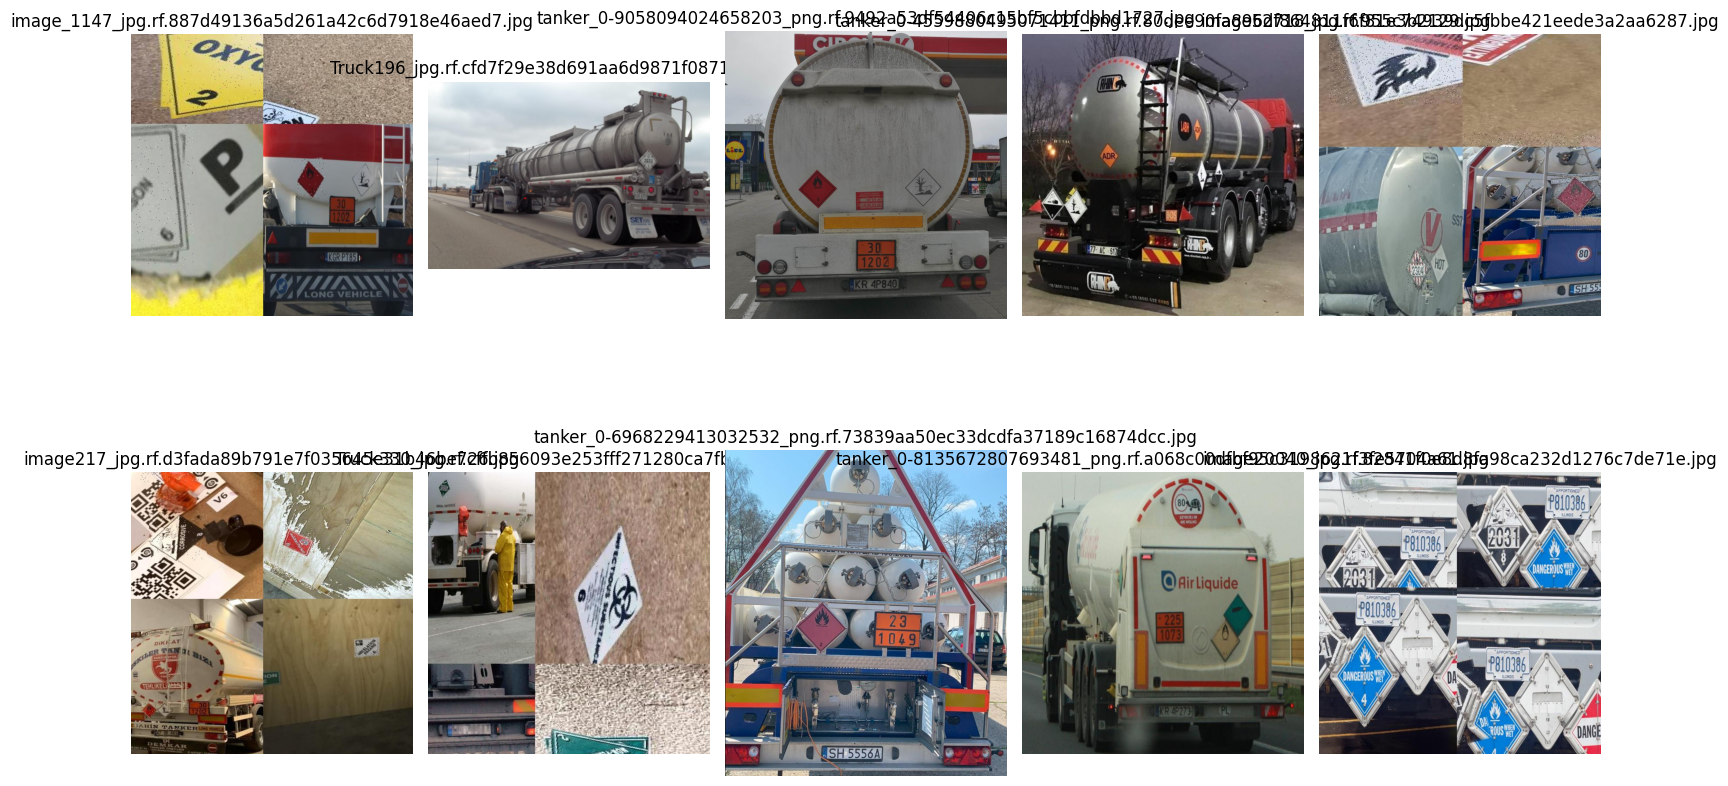

In [4]:
import os
import random
import cv2
import matplotlib.pyplot as plt

image_folder = 'merged_dataset/images'
label_folder = 'merged_dataset/labels'

target_class_name = 'explosive substances' 

class_id = class_names.index(target_class_name)

image_files = []
for label_file in os.listdir(label_folder):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_folder, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                values = line.strip().split()
                if int(values[0]) == class_id:  
                    image_name = label_file.replace('.txt', '.jpg')  
                    image_files.append(image_name)
                    break  

print(f"Số lượng ảnh tìm thấy cho lớp '{target_class_name}': {len(image_files)}")

if len(image_files) > 0:
    random_images = random.sample(image_files, min(10, len(image_files)))

    plt.figure(figsize=(15, 10))
    for i, image_name in enumerate(random_images):
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_name}. Skipping.")
            continue  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(image_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy ảnh nào cho lớp này.")

In [7]:
import shutil
image_folder = 'merged_dataset_v1/images'
label_folder = 'merged_dataset_v1/labels'
new_image_folder = 'filtered_images'

# Tên lớp mà bạn muốn in ảnh
target_class_name = 'explosive substances'  # Thay thế bằng tên lớp bạn muốn

# Tìm ID của lớp
class_id = class_names.index(target_class_name)

# Lưu danh sách các bức ảnh có label tương ứng
image_files = []
for label_file in os.listdir(label_folder):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_folder, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                values = line.strip().split()
                if int(values[0]) == class_id:  # Kiểm tra ID lớp
                    image_name = label_file.replace('.txt', '.jpg')  # Thay đổi đuôi nếu cần
                    image_files.append(image_name)
                    break  # Chỉ cần một lần xuất hiện là đủ

# Kiểm tra số lượng ảnh tìm thấy
print(f"Số lượng ảnh tìm thấy cho lớp '{target_class_name}': {len(image_files)}")

# Tạo thư mục mới nếu chưa tồn tại
os.makedirs(new_image_folder, exist_ok=True)

# Sao chép các ảnh vào thư mục mới
for image_name in image_files:
    source_image_path = os.path.join(image_folder, image_name)
    dest_image_path = os.path.join(new_image_folder, image_name)
    shutil.copy(source_image_path, dest_image_path)  # Sao chép ảnh

print(f"Đã sao chép {len(image_files)} ảnh vào thư mục '{new_image_folder}'.")

Số lượng ảnh tìm thấy cho lớp 'explosive substances': 9
Đã sao chép 9 ảnh vào thư mục 'filtered_images'.


In [2]:
print(len(class_names))

33


In [4]:
from ultralytics import YOLO

# Load a model
model = YOLO("runs_v3/detect/train/weights/best.pt")
results = model("output_images/raw_data/01-transporting-class-9-hazmat.jpg")
results[0].show()



image 1/1 d:\Nam_Workspace\hazardous_detection\output_images\raw_data\01-transporting-class-9-hazmat.jpg: 320x640 1 Corrosive, 1 Env Hazardous, 1 Flammable Liquid Combustible, 1 Miscellaneous, 232.8ms
Speed: 33.7ms preprocess, 232.8ms inference, 33.3ms postprocess per image at shape (1, 3, 320, 640)


In [1]:
import supervision as sv
from ultralytics import YOLO
import numpy as np
# 1. Load model
model = YOLO("runs_RT_BETR/detect/train4/weights/best.pt")
# 2. Load dataset 
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path='merged_dataset_v1/val/images',
    annotations_directory_path='merged_dataset_v1/val/labels',
    data_yaml_path="merged_dataset_v1/data.yaml"
)

In [2]:
len(dataset)

3891

In [3]:
dataset.classes

['Combustible',
 'Corrosive',
 'Dangerous',
 'Dangerous Wet',
 'Env Hazardous',
 'Explosives',
 'Explosives No Mass Risk',
 'Explosives Blasting',
 'Explosives Low Risk',
 'Explosives Minor Blast',
 'Explosives Mass Explosion',
 'Explosives Projectile Hazard',
 'Flammable',
 'Flammable Liquid Combustible',
 'Flammable Gases',
 'Flammable Liquid',
 'Flammable Solids',
 'Fuel Oil',
 'Hot',
 'Infectious',
 'Miscellaneous',
 'Nonflammable Gases',
 'Orange Panel',
 'Organic Peroxide',
 'Oxidizer',
 'Oxidizing',
 'Oxygen',
 'Placards',
 'Poison',
 'Radioactive',
 'Spont Combustible',
 'Toxic Gases',
 'License Plate']

In [4]:
IMAGE_NAME = list(dataset.images.keys())[0]

image = dataset.images[IMAGE_NAME]
annotations = dataset.annotations[IMAGE_NAME]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()

labels = [f"{dataset.classes[class_id]}" for class_id in annotations.class_id]

annotated_image = mask_annotator.annotate(image.copy(), detections=annotations)
annotated_image = box_annotator.annotate(annotated_image, detections=annotations)
annotated_image = label_annotator.annotate(
    annotated_image, detections=annotations, labels=labels
)

sv.plot_image(image=annotated_image, size=(8, 8))

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
